# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Легенда

### Признаки:
- `RowNumber` — индекс строки в данных
- `CustomerId` — уникальный идентификатор клиента
- `Surname` — фамилия
- `CreditScore` — кредитный рейтинг
- `Geography` — страна проживания
- `Gender` — пол
- `Age` — возраст
- `Tenure` — количество недвижимости у клиента
- `Balance` — баланс на счёте
- `NumOfProducts` — количество продуктов банка, используемых клиентом
- `HasCrCard` — наличие кредитной карты
- `IsActiveMember` — активность клиента
- `EstimatedSalary` — предполагаемая зарплата

### Целевой признак:
- `Exited` — факт ухода клиента

Этапы работы
1. [Подготовка данных](#section1)
2. [Исследование моделей](#section2)
3. [Тестирование модели](#section3)

<a id = 'section1'></a>
#  Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.utils import shuffle

In [3]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

In [4]:
df = pd.read_csv('/datasets/Churn.csv')

In [5]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Приведем наименование столбцов к нижнему регистру. На мой взгляд такие признаки как `rownumber`, `customerid`, `surname`несут лишь информативный характер, глупо предполагать что твой id и твоя фамилия оказывают влияние на твое финансовое поведение, остаться клиентом банка или нет, поэтому смело отбросим избыточную информацию.

In [6]:
df.columns = df.columns.str.lower()
df = df.drop(['rownumber', 'customerid', 'surname'], axis = 1)

In [7]:
df.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [8]:
df['geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: geography, dtype: int64

Проведем небольшой предварительный анализ имеющихся данных

In [9]:
df.dtypes

creditscore          int64
geography           object
gender              object
age                  int64
tenure             float64
balance            float64
numofproducts        int64
hascrcard            int64
isactivemember       int64
estimatedsalary    float64
exited               int64
dtype: object

In [10]:
df.describe()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [11]:
df.isna().mean()

creditscore        0.0000
geography          0.0000
gender             0.0000
age                0.0000
tenure             0.0909
balance            0.0000
numofproducts      0.0000
hascrcard          0.0000
isactivemember     0.0000
estimatedsalary    0.0000
exited             0.0000
dtype: float64

In [12]:
len(df[df['balance'] == 0])/len(df)

0.3617

36% клиентов имеют 0 баланс на счете, можем предположить, что люди не сильно заинтересованы в услугах данного банка.  У многих открыты зарплатные счета в тех банках, в которых открыт зарплатный проект у работадателя, и многие после получения зп переводят средства в сторонний банк. Нулевой баланс почти у 40% клиентов, поэтому хочу выделить такую закономерность в отдельный признак `zero_balance` если остаток нулевой то значение 1 и наоборот.

In [13]:
df['zero_balance'] = df['balance'].isin([0])*1

In [14]:
df.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,zero_balance
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,0
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,1
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,0


Фокус удался. Разделем выборку на признаки и целевой признак. Выделим тестовую и учебную выборки. При обучении будем использовать кросс валидацию, поэтому валидационной выборки не будет.

In [15]:
x = df.drop('exited', axis = 1)
y = df.exited

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, stratify = y, random_state = 0)

In [17]:
print ('Распеределение целевого признака на выборке:', round(y.mean(), 5))
print ('Распеределение целевого признака на обучающей выборке:', round(y_train.mean(), 5))
print ('Распеределение целевого признака на тестовой выборке:', round(y_test.mean(), 5))

Распеределение целевого признака на выборке: 0.2037
Распеределение целевого признака на обучающей выборке: 0.20373
Распеределение целевого признака на тестовой выборке: 0.2036


Получили достаточно равномерное распределение признака в выборках целевого признака. Однако достаточно маленькая доля `exited = 1`, что может негативно отразиться на предсказательной моделе. Посмотрим что получиться, затем будем заниматься балансировкой.

In [18]:
df.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,zero_balance
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1,0
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0,1
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0,0


Напишем общий pipeline для предобработки данных

Первый шаг pipeline - напишум логику для заполнения пропущенных значений, для категориальных по моде, для численных значений по медиане

In [19]:
trf1 = ColumnTransformer(transformers =[
    ('cat', SimpleImputer(strategy ='most_frequent'), [
        'geography', 'gender', 'numofproducts','hascrcard', 'isactivemember', 'zero_balance'
    ]),
    
    ('num', SimpleImputer(strategy ='median'), ['creditscore', 'age', 'tenure', 'balance', 'estimatedsalary']),
      
], remainder ='passthrough')

In [20]:
first_step = trf1.fit_transform(x_train)

In [21]:
pd.DataFrame(first_step)

,0,1,2,3,4,5,6,7,8,9,10
0,Spain,Female,1,1,0,1,544,53,9,0,125692
1,Germany,Male,1,1,0,0,747,38,2,129729,89289.5
2,France,Male,1,1,1,0,642,40,5,154863,138053
3,France,Female,1,1,0,1,593,41,6,0,65170.7
4,France,Male,1,1,0,0,464,46,6,161799,182944
...,...,...,...,...,...,...,...,...,...,...,...
7495,Spain,Male,2,1,0,1,644,18,8,0,59172.4
7496,Germany,Male,2,0,1,0,850,41,1,176958,125806
7497,Germany,Female,1,1,1,0,697,38,6,132591,7387.8
7498,France,Female,2,1,1,0,722,35,2,163944,15068.2


In [22]:
pd.DataFrame(first_step, columns=x.columns).isna().mean()

creditscore        0.0
geography          0.0
gender             0.0
age                0.0
tenure             0.0
balance            0.0
numofproducts      0.0
hascrcard          0.0
isactivemember     0.0
estimatedsalary    0.0
zero_balance       0.0
dtype: float64

Мини проверка - пропущенных значений нет, можно двигаться дальше

Второй шаг - используем OHE для преобразование наших признаков, данный метод подходит как для логистической регресси так и для деревьев

In [23]:
trf2 = ColumnTransformer(transformers =[
    ('enc', OneHotEncoder(sparse = False, drop ='first'), list(range(2))),
], remainder ='passthrough')

In [24]:
second_step = trf2.fit_transform(x_train)

In [25]:
pd.DataFrame(second_step)

,0,1,2,3,4,5,6,7,8,9,...,455,456,457,458,459,460,461,462,463,464
0,0,0,0,0,0,0,0,0,0,0,...,1,Female,53,9,0,1,1,0,125692,1
1,0,0,0,0,0,0,0,0,0,0,...,0,Male,38,2,129729,1,1,0,89289.5,0
2,0,0,0,0,0,0,0,0,0,0,...,0,Male,40,NaN,154863,1,1,1,138053,0
3,0,0,0,0,0,0,0,0,0,0,...,0,Female,41,6,0,1,1,0,65170.7,1
4,0,0,0,0,0,0,0,0,0,0,...,0,Male,46,6,161799,1,1,0,182944,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,0,0,0,0,0,0,0,0,0,0,...,1,Male,18,8,0,2,1,0,59172.4,1
7496,0,0,0,0,0,0,0,0,0,0,...,0,Male,41,1,176958,2,0,1,125806,0
7497,0,0,0,0,0,0,0,0,0,0,...,0,Female,38,6,132591,1,1,1,7387.8,0
7498,0,0,0,0,0,0,0,0,0,0,...,0,Female,35,2,163944,2,1,1,15068.2,0


Мини проверка - все работает

Собираем наш "водопровод" для Логистической регрессии

In [26]:
pipe_logreg = Pipeline(steps =[
    ('tf1', trf1),
    ('tf2', trf2),
    ('tf3', StandardScaler()),
    ('model_logreg', LogisticRegression(random_state = 0, solver ='liblinear')),
])

<div class="alert alert-block alert-success">
<b>Успех:</b> Тебе удалось очень хорошо овладеть механизмом пайплайнов, это очень радует!
</div>

<a id = 'section2'></a>
# Исследование моделей

## Логистическая регрессия

Обучаем логистическую регрессию на трейне без подбора гиперпараметров и при имеющемя дизбалансе. Смотрим какой f1_score мы получили

In [27]:
pipe_logreg.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('tf1',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='most_frequent',
                                                                verbose=0),
                                                  ['geography', 'gender',
                                                   'numofproducts', 'hascrcard',
                                                   'isactive

In [28]:
f1_score(y_test, pipe_logreg.predict(x_test))

0.3136690647482015

f1_score всего 0,31 - весьма далеко от значения 0,59. Модель плохо распознает положительные классы, так же как и  предсказывает их. 

Напишем сетку для для RandomizedSearchCV для оптимизации гиперпараметров.

In [29]:
pipe_logreg_params = {'model_logreg__C': np.arange(1.0, 100.0, .1),
                      'model_logreg__dual': [True, False],
                      'model_logreg__fit_intercept': [True, False],
                      'model_logreg__class_weight': [None, 'balanced'],
                      'model_logreg__max_iter': range(200000, 300000),
                     }

In [30]:
prs_logreg = RandomizedSearchCV(pipe_logreg, pipe_logreg_params, cv = 5, n_iter = 50, scoring = 'f1')

Обучим модель по сетке, с поиском наилучших гиперпараметров

In [31]:
prs_logreg.fit(x_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('tf1',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='passthrough',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('cat',
                                                                               SimpleImputer(add_indicator=False,
                                                                                             copy=True,
                                                                                             fill_value=None,
                                                                                  

Посмотрим наилучшии параметры после 50 итераций по сетке

In [32]:
prs_logreg.best_params_

{'model_logreg__max_iter': 281677,
 'model_logreg__fit_intercept': True,
 'model_logreg__dual': True,
 'model_logreg__class_weight': 'balanced',
 'model_logreg__C': 17.400000000000013}

In [33]:
prs_logreg.best_score_

0.4943180944303058

После 50 итераций наилучшее рандомные параметры:

- max_iter: 282263,
- fit_intercept: True,
- dual: True,
- class_weight: balanced,
- C: 3.300000000000002

Следует отметить, что наиболее редкому классу передан больший вес с помощью параметра `class_weight`.
F1_score равен 0,49 что намного лучше начальной модели, но все еще далеко до идеала

Зафиксируем модель, что бы при повторном запуске тетради модель обучалась уже заранее найдеными мной параметрами, указаные выше.

In [34]:
pipe_logreg = Pipeline(steps =[
    ('tf1', trf1),
    ('tf2', trf2),
    ('tf3', StandardScaler()),
    ('model_logreg', LogisticRegression(random_state=42,
                                        max_iter = 282263,
                                        fit_intercept = True,
                                        dual = True,
                                        class_weight = 'balanced',
                                        C = 3.300000000000002,
                                        solver ='liblinear')),
])

In [35]:
pipe_logreg.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('tf1',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='most_frequent',
                                                                verbose=0),
                                                  ['geography', 'gender',
                                                   'numofproducts', 'hascrcard',
                                                   'isactive

In [36]:
f1_score(y_test, pipe_logreg.predict(x_test))

0.49794238683127573

Напишем функцию Upsampling наших данных и посмотрим как ведет себя логистическая регрессия на сбалансированной выборке

In [37]:
def upsample(x, y, repeat):
    x_zeros = x[y == 0]
    x_ones = x[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]

    x_upsampled = pd.concat([x_zeros] + [x_ones] * repeat)
    y_upsampled = pd.concat([y_zeros] + [y_ones] * repeat)
    
    x_upsampled, y_upsampled = shuffle(x_upsampled, y_upsampled, random_state=42)
    
    return x_upsampled, y_upsampled

In [38]:
x_upsampled, y_upsampled = upsample(x_train, y_train, 4)

In [39]:
y_upsampled.mean()

0.5057927838464085

отлично 1 столько же сколько и 0. Теперь загоним все в водопровод и обучим ту же модель но уже на сбалансированных данных

In [40]:
pipe_logreg_upsampled = Pipeline(steps =[
    ('tf1', trf1),
    ('tf2', trf2),
    ('tf3', StandardScaler()),
    ('model_logreg', LogisticRegression(random_state=42,
                                        max_iter = 282263,
                                        fit_intercept = True,
                                        dual = True,
                                        class_weight = 'balanced',
                                        C = 3.300000000000002,
                                        solver ='liblinear')),
])

In [41]:
pipe_logreg_upsampled.fit(x_upsampled, y_upsampled)

Pipeline(memory=None,
         steps=[('tf1',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='most_frequent',
                                                                verbose=0),
                                                  ['geography', 'gender',
                                                   'numofproducts', 'hascrcard',
                                                   'isactive

In [42]:
f1_score(y_train, pipe_logreg.predict(x_train))

0.49765917602996246

In [43]:
f1_score(y_upsampled, pipe_logreg_upsampled.predict(x_upsampled))

0.7060190950601909

In [44]:
f1_score(y_test, pipe_logreg.predict(x_test))

0.49794238683127573

In [45]:
f1_score(y_test, pipe_logreg_upsampled.predict(x_test))

0.49794238683127573

Значение F1 получилось намного выше на Upsampling данных 0.7060190950601909, чем на обычных данных 0.49765917602996246. Однако на тестовых данных результат один и тот же. Не совсем понимаю почему так происходит. Читал статью о том, что нельзя делать Upsampling перед CV,так как моделька переобучается за счет того что выборка не репрезентативная и что повторяющие данные могут одновременно попасть как в трейн так и в тест при CV и она переобучиться, поэтому учил модельку после того как были подобраны гиперпараметры по RandomizedSearchCV. 

Напишем функцию Downsampling наших данных и посмотрим как ведет себя логистическая регрессия на сбалансированной выборке

Downsampling

In [46]:
def downsample(x, y, fraction):
    x_zeros = x[y == 0]
    x_ones = x[y == 1]
    y_zeros = y[y == 0]
    y_ones = y[y == 1]
    
    x_downsampled = pd.concat(
        [x_zeros.sample(frac=fraction, random_state=42)] + [x_ones])
    y_downsampled = pd.concat(
        [y_zeros.sample(frac=fraction, random_state=42)] + [y_ones])
    
    x_downsampled, y_downsampled = shuffle(
        x_downsampled, y_downsampled, random_state=42)
    
    return x_downsampled, y_downsampled

In [47]:
x_downsampled, y_downsampled = downsample(x_train, y_train, 0.25)

In [48]:
y_train.mean()

0.20373333333333332

In [49]:
y_downsampled.mean()

0.5057927838464085

отлично 1 столько же сколько и 0. Теперь загоним все в водопровод и обучим ту же модель но уже на сбалансированных данных

In [50]:
pipe_logreg_downsampled = Pipeline(steps =[
    ('tf1', trf1),
    ('tf2', trf2),
    ('tf3', StandardScaler()),
    ('model_logreg', LogisticRegression(random_state=42,
                                        max_iter = 282263,
                                        fit_intercept = True,
                                        dual = True,
                                        class_weight = 'balanced',
                                        C = 3.300000000000002,
                                        solver ='liblinear')),
])

In [51]:
pipe_logreg_downsampled.fit(x_downsampled, y_downsampled)

Pipeline(memory=None,
         steps=[('tf1',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='most_frequent',
                                                                verbose=0),
                                                  ['geography', 'gender',
                                                   'numofproducts', 'hascrcard',
                                                   'isactive

In [52]:
f1_score(y_train, pipe_logreg.predict(x_train))

0.49765917602996246

In [53]:
f1_score(y_downsampled, pipe_logreg_downsampled.predict(x_downsampled))

0.7043941411451398

In [54]:
f1_score(y_test, pipe_logreg.predict(x_test))

0.49794238683127573

In [55]:
f1_score(y_test, pipe_logreg_downsampled.predict(x_test))

0.48415374241402553

Значение F1 получилось намного выше на Downsampling данных 0.7043941411451398, чем на обычных данных 0.49765917602996246. Однако на тестовых данных результат Downsampling ниже. Поиграл немного со значением frac - получается что на тесте f1_score выше на Downsampling выборке, но на тесте всегда ниже.

Изучим как ведет себя метрика Roc_auc для Логистической Регрессии

In [56]:
probabilities_one_logreg = pipe_logreg.predict_proba(x_test)[:, 1]

In [57]:
auc_logreg = roc_auc_score(y_test, probabilities_one_logreg)
print('LogisticRegression: ROC AUC=%.3f' % (auc_logreg))

LogisticRegression: ROC AUC=0.772


Значение 0.772 лучше рандома, но так же далеко до идеала

In [58]:
fpr_logreg, tpr_logreg, treshold_logreg = roc_curve(y_test, probabilities_one_logreg)

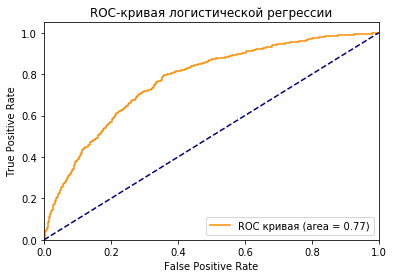

In [59]:
plt.plot(fpr_logreg, tpr_logreg, color='darkorange',
         label='ROC кривая (area = %0.2f)' % auc_logreg)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая логистической регрессии')
plt.legend(loc="lower right")
plt.show()

## Дерево решений

Собираем наш "водопровод" для Дерева решений

In [60]:
pipe_tree = Pipeline(steps =[
    ('tf1', trf1),
    ('tf2', trf2),
    ('tf3', StandardScaler()),
    ('model_tree', DecisionTreeClassifier(random_state = 42)),
])

In [61]:
pipe_tree.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('tf1',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='most_frequent',
                                                                verbose=0),
                                                  ['geography', 'gender',
                                                   'numofproducts', 'hascrcard',
                                                   'isactive

Обучаем дерева решений на трейне без подбора гиперпараметров и при имеющемя дизбалансе. Смотрим какой f1_score мы получили

In [62]:
f1_score(y_test, pipe_tree.predict(x_test))

0.5134615384615384

f1_score всего 0,50 - не так далеко от 0,59. Оптимизируем за счет подбора гиперпараметров

In [63]:
pipe_tree_params= {'model_tree__max_depth':range(1,11),
                   'model_tree__min_samples_split':range(2, 22),
                   'model_tree__min_samples_leaf':range(1,20),
                   'model_tree__max_features':range(1, 12),
                   'model_tree__class_weight': [None, 'balanced'],
                   'model_tree__criterion':['gini', 'entropy']
                  }

In [64]:
prs_tree = RandomizedSearchCV(pipe_tree, pipe_tree_params, cv = 5, n_iter = 500, scoring = 'f1')

In [65]:
prs_tree.fit(x_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('tf1',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='passthrough',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('cat',
                                                                               SimpleImputer(add_indicator=False,
                                                                                             copy=True,
                                                                                             fill_value=None,
                                                                                  

In [66]:
prs_tree.best_score_

0.5853070272876301

После 50 итераций наилучшее рандомные параметры:

- min_samples_split: 12,
- min_samples_leaf: 18,
- max_feature : 11,
- max_features: 9,
- criterion: entropy,
- class_weight: None

F1_score равен 0,58 что намного лучше начальной модели и ближе к искомому значению

In [67]:
prs_tree.best_params_

{'model_tree__min_samples_split': 17,
 'model_tree__min_samples_leaf': 13,
 'model_tree__max_features': 10,
 'model_tree__max_depth': 7,
 'model_tree__criterion': 'entropy',
 'model_tree__class_weight': 'balanced'}

Зафиксируем модель

In [68]:
pipe_tree = Pipeline(steps =[
    ('tf1', trf1),
    ('tf2', trf2),
    ('tf3', StandardScaler()),
    ('model_tree', DecisionTreeClassifier(random_state = 0,
                                         min_samples_split = 12,
                                         min_samples_leaf = 18,
                                         max_features = 11,
                                         max_depth = 9,
                                         criterion = 'entropy',
                                         class_weight = None)),
])

In [69]:
pipe_tree.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('tf1',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='most_frequent',
                                                                verbose=0),
                                                  ['geography', 'gender',
                                                   'numofproducts', 'hascrcard',
                                                   'isactive

Посмотрим как ведет себя  дерево решений на сбалансированной выборке

In [70]:
pipe_tree_upsampled = Pipeline(steps =[
    ('tf1', trf1),
    ('tf2', trf2),
    ('tf3', StandardScaler()),
    ('model_tree', DecisionTreeClassifier(random_state = 0,
                                         min_samples_split = 12,
                                         min_samples_leaf = 18,
                                         max_features = 11,
                                         max_depth = 9,
                                         criterion = 'entropy',
                                         class_weight = None)),
])

In [71]:
pipe_tree_upsampled.fit(x_upsampled, y_upsampled)

Pipeline(memory=None,
         steps=[('tf1',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='most_frequent',
                                                                verbose=0),
                                                  ['geography', 'gender',
                                                   'numofproducts', 'hascrcard',
                                                   'isactive

In [72]:
f1_score(y_train, pipe_tree.predict(x_train))

0.6178600160901047

In [73]:
f1_score(y_upsampled, pipe_tree_upsampled.predict(x_upsampled))

0.8163942586907824

In [74]:
f1_score(y_test, pipe_tree.predict(x_test))

0.5477075588599752

In [75]:
f1_score(y_test, pipe_tree_upsampled.predict(x_test))

0.5672609400324149

Значение F1 на трейне получилось намного выше (0.8163942586907824), чем без Upsampling (0.6178600160901047), на тесте дало немного лучшее значение, чем без upsampling

In [76]:
pipe_tree_downsampled = Pipeline(steps =[
    ('tf1', trf1),
    ('tf2', trf2),
    ('tf3', StandardScaler()),
    ('model_tree', DecisionTreeClassifier(random_state = 0,
                                         min_samples_split = 12,
                                         min_samples_leaf = 18,
                                         max_features = 11,
                                         max_depth = 9,
                                         criterion = 'entropy',
                                         class_weight = None)),
])

In [77]:
pipe_tree_downsampled.fit(x_downsampled, y_downsampled)

Pipeline(memory=None,
         steps=[('tf1',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='most_frequent',
                                                                verbose=0),
                                                  ['geography', 'gender',
                                                   'numofproducts', 'hascrcard',
                                                   'isactive

In [78]:
f1_score(y_train, pipe_tree.predict(x_train))

0.6178600160901047

In [79]:
f1_score(y_downsampled, pipe_tree_downsampled.predict(x_downsampled))

0.8131212723658052

In [80]:
f1_score(y_test, pipe_tree.predict(x_test))

0.5477075588599752

In [81]:
f1_score(y_test, pipe_tree_downsampled.predict(x_test))

0.5668449197860963

Значение F1 на трейне получилось намного выше (0.8131212723658052), чем без Upsampling (0.6178600160901047), на тесте дало немного лучшее значение

Изучим как ведет себя метрика Roc_auc для Дерева решений

In [82]:
probabilities_one_tree = pipe_tree_upsampled.predict_proba(x_test)[:, 1]

In [83]:
auc_tree = roc_auc_score(y_test, probabilities_one_tree)
print('DecisionTreeClassifier: ROC AUC=%.3f' % (auc_tree))

DecisionTreeClassifier: ROC AUC=0.810


Значение 0.808 лучше рандома, но так же далеко до идеала

In [84]:
fpr_tree, tpr_tree, treshold_tree = roc_curve(y_test, probabilities_one_tree)

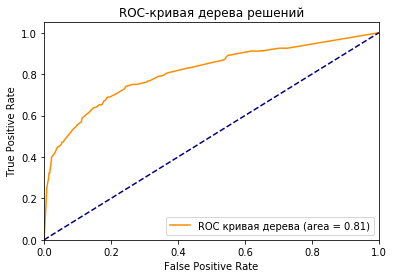

In [85]:
plt.plot(fpr_tree, tpr_tree, color='darkorange',
         label='ROC кривая дерева (area = %0.2f)' % auc_tree)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая дерева решений')
plt.legend(loc="lower right")
plt.show()

## Случайный лес

Собираем наш "водопровод" для Случайного леса

In [86]:
pipe_random = Pipeline(steps =[
    ('tf1', trf1),
    ('tf2', trf2),
    ('tf3', StandardScaler()),
    ('model_random', RandomForestClassifier(random_state = 0)),
])

Обучаем дерева решений на трейне без подбора гиперпараметров и при имеющемя дизбалансе. Смотрим какой f1_score мы получили

In [87]:
pipe_random.fit(x_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('tf1',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='most_frequent',
                                                                verbose=0),
                                                  ['geography', 'gender',
                                                   'numofproducts', 'hascrcard',
                                                   'isactive

f1_score всего 0,54 - не так далеко от 0,59. Оптимизируем за счет подбора гиперпараметров

In [88]:
f1_score(y_test, pipe_random.predict(x_test))

0.5443499392466585

In [89]:
pipe_random_params= {'model_random__n_estimators':range(1,11),
                     'model_random__max_depth':range(1,11),
                     'model_random__min_samples_split':range(2, 22),
                     'model_random__min_samples_leaf':range(1,20),
                     'model_random__max_features':range(1, 12),
                     'model_random__bootstrap':[True, False],
                     'model_random__class_weight': [None, 'balanced'],
                     'model_random__criterion':['gini', 'entropy']
                    }

In [90]:
prs_random = RandomizedSearchCV(pipe_random, pipe_random_params, cv = 5, n_iter = 500, scoring = 'f1')

In [91]:
prs_random.fit(x_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('tf1',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='passthrough',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('cat',
                                                                               SimpleImputer(add_indicator=False,
                                                                                             copy=True,
                                                                                             fill_value=None,
                                                                                  

In [92]:
prs_random.best_score_

0.6187323607723041

In [93]:
prs_random.best_params_

{'model_random__n_estimators': 9,
 'model_random__min_samples_split': 14,
 'model_random__min_samples_leaf': 12,
 'model_random__max_features': 11,
 'model_random__max_depth': 9,
 'model_random__criterion': 'entropy',
 'model_random__class_weight': 'balanced',
 'model_random__bootstrap': True}

После 50 итераций наилучшее рандомные параметры:

- n_estimators: 8,
- min_samples_split: 5,
- min_samples_leaf : 12,
- max_features: 11,
- max_depth: 9,
- criterion: entropy,
- class_weight: balanced
- bootstrap: True

Следует отметить, что наиболее редкому классу передан больший вес с помощью параметра `class_weight`.
F1_score равен 0,61 что выше требуемого значения в поставленной задаче

Зафиксируем модель

In [94]:
pipe_random = Pipeline(steps =[
    ('tf1', trf1),
    ('tf2', trf2),
    ('tf3', StandardScaler()),
    ('model_random', RandomForestClassifier(random_state = 0,
                                           n_estimators = 8,
                                           min_samples_split = 5,
                                           min_samples_leaf = 12,
                                           max_features = 11,
                                           max_depth = 9,
                                           criterion = 'entropy',
                                           class_weight = 'balanced',
                                           bootstrap = True)),
])

In [95]:
pipe_random.fit(x_train, y_train)

Pipeline(memory=None,
         steps=[('tf1',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='most_frequent',
                                                                verbose=0),
                                                  ['geography', 'gender',
                                                   'numofproducts', 'hascrcard',
                                                   'isactive

Посмотрим как ведет себя  случайный лес на сбалансированной выборке

In [96]:
pipe_random_upsampled = Pipeline(steps =[
    ('tf1', trf1),
    ('tf2', trf2),
    ('tf3', StandardScaler()),
    ('model_random', RandomForestClassifier(random_state = 0,
                                           n_estimators = 8,
                                           min_samples_split = 5,
                                           min_samples_leaf = 12,
                                           max_features = 11,
                                           max_depth = 9,
                                           criterion = 'entropy',
                                           class_weight = 'balanced',
                                           bootstrap = True)),
])

In [97]:
pipe_random_upsampled.fit(x_upsampled, y_upsampled)

Pipeline(memory=None,
         steps=[('tf1',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='most_frequent',
                                                                verbose=0),
                                                  ['geography', 'gender',
                                                   'numofproducts', 'hascrcard',
                                                   'isactive

In [98]:
f1_score(y_train, pipe_random.predict(x_train))

0.6883590462833099

In [99]:
f1_score(y_upsampled, pipe_random_upsampled.predict(x_upsampled))

0.8485851398312096

In [100]:
f1_score(y_test, pipe_random.predict(x_test))

0.6024518388791594

In [101]:
f1_score(y_test, pipe_random_upsampled.predict(x_test))

0.5906821963394343

Значение F1 на трейне получилось намного выше (0.8485851398312096), чем без Upsampling (0.6883590462833099), на тесте дало значение немного хуже. Посмотрим, что даст downsampling

In [102]:
pipe_random_downsampled = Pipeline(steps =[
    ('tf1', trf1),
    ('tf2', trf2),
    ('tf3', StandardScaler()),
    ('model_random', RandomForestClassifier(random_state = 0,
                                           n_estimators = 8,
                                           min_samples_split = 5,
                                           min_samples_leaf = 12,
                                           max_features = 11,
                                           max_depth = 9,
                                           criterion = 'entropy',
                                           class_weight = 'balanced',
                                           bootstrap = True)),
])

In [103]:
pipe_random_downsampled.fit(x_downsampled, y_downsampled)

Pipeline(memory=None,
         steps=[('tf1',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  SimpleImputer(add_indicator=False,
                                                                copy=True,
                                                                fill_value=None,
                                                                missing_values=nan,
                                                                strategy='most_frequent',
                                                                verbose=0),
                                                  ['geography', 'gender',
                                                   'numofproducts', 'hascrcard',
                                                   'isactive

In [104]:
f1_score(y_train, pipe_random.predict(x_train))

0.6883590462833099

In [105]:
f1_score(y_downsampled, pipe_random_downsampled.predict(x_downsampled))

0.8197267577474174

In [106]:
f1_score(y_test, pipe_random.predict(x_test))

0.6024518388791594

In [107]:
f1_score(y_test, pipe_random_downsampled.predict(x_test))

0.5822981366459626

Значение F1 на трейне получилось намного выше (0.8197267577474174), чем без Downsampling (0.6883590462833099), на тесте дало значение немного хуже

Изучим как ведет себя метрика Roc_auc для Случайного леса

In [108]:
probabilities_one_random= pipe_random.predict_proba(x_test)[:, 1]

In [109]:
auc_random = roc_auc_score(y_test, probabilities_one_random)
print('RandomForestClassifier: ROC AUC=%.3f' % (auc_random))

RandomForestClassifier: ROC AUC=0.845


Значение 0.845 наибольшее из 3 моделей

In [110]:
fpr_random, tpr_random, treshold_random = roc_curve(y_test, probabilities_one_random)

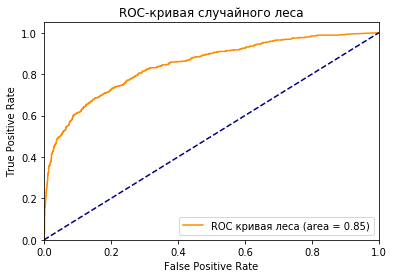

In [111]:
plt.plot(fpr_random, tpr_random, color='darkorange',
         label='ROC кривая леса (area = %0.2f)' % auc_random)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая случайного леса')
plt.legend(loc="lower right")
plt.show()

## Общий вывод

Построим сводную таблицу по моделям

In [112]:
col_sum = ['f1_score на модели без оптимизации', 'f1_score на модели с подбором гиперпараметров', 'roc_auc_score']

In [113]:
dt = {'Логистическая регрессия':[0.31, 0.49, 0.77],
        'Дерево решений': [0.50, 0.58, 0.81],
        'Случайный лес': [0.54, 0.61, 0.85]}

In [114]:
summary = pd.DataFrame.from_dict(data = dt, orient='index', columns = col_sum)
summary

,f1_score на модели без оптимизации,f1_score на модели с подбором гиперпараметров,roc_auc_score
Логистическая регрессия,0.31,0.49,0.77
Дерево решений,0.50,0.58,0.81
Случайный лес,0.54,0.61,0.85


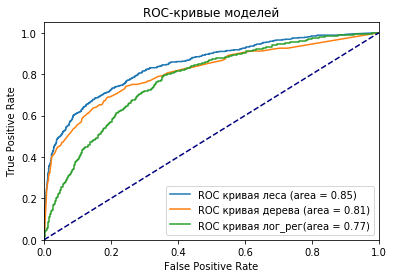

In [115]:
plt.plot(fpr_random, tpr_random,
         label='ROC кривая леса (area = %0.2f)' % auc_random)
plt.plot(fpr_tree, tpr_tree,
         label='ROC кривая дерева (area = %0.2f)' % auc_tree)
plt.plot(fpr_logreg, tpr_logreg,
         label='ROC кривая лог_рег(area = %0.2f)' % auc_logreg)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые моделей')
plt.legend(loc="lower right")
plt.show()

Исходя из полученных данных, наилучшей моделью следует считать Случайный лес с f1_score 0.61 и roc_auc 0.85

<a id = 'section3'></a>
# Тестирование модели

Проверим метрики построенных моделей на тестовой выборке

In [116]:
f1_score(y_test, pipe_logreg.predict(x_test))

0.49794238683127573

In [117]:
f1_score(y_test, pipe_tree_upsampled.predict(x_test))

0.5672609400324149

In [118]:
f1_score(y_test, pipe_random.predict(x_test))

0.6024518388791594

По прежнему наилучшей моделью является случйный лес с f1_score 0.60 b auc_score 0.85

## Общий вывод: 
Наилучшая модель классификации среди опробаванных опять стал случайны лес с f1_score 0.60 и auc_score 0.85. Так как в проекте была использована кросс валидация, конкертно в данной работе дизбаланс класса не сильно повлиял на целевые метрики. В ходе работы были применены методы борьбы с дисбалансом такие как предания более значимого веса более редкому классу (class_weight = 'balanced'). Опробованы методы upsampling  и downsampling, если мной не было допущено критических ошибок, то во моем случаи данные методы увеличивают значение целевой метрики на трейне, но на тесте не сильно увеличивают целевую метрику, порой и наоборот. Модели обучены с помощью pipline, что сильно упростило подготовку данных и обучение моделей.